Contents:

I. Understand the problem and Module Imports

II. Reading Data into the Notebook

III. Train - Valid - Test split

IV. Data Pre-processing

V. First model

VI. Hyperparameter tuning

VII. Combining the train and validation datasets

VIII. Building Saving the model to disk

# I. Understand the problem and Module imports

In [1]:
'''Please visit the kaggle webpage, https://www.kaggle.com/c/titanic.
Make sure we understand the problem and what we need to predict. What
score or metric are we optimizing for !'''

'''Import all necessary packages 
(1) pandas for data munging
(2) pandas api types for correct datatyping
(3) preprocessing module from scikit-learn (sklearn)
(4) model metrics from sklearn
(5) matplotlib and seaborn for data visualization
(6) joblib for saving the model'''


import pandas as pd
from pandas.api.types import is_string_dtype,is_numeric_dtype
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,matthews_corrcoef,f1_score
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.externals import joblib

%matplotlib inline

# II. Reading data into the notebook

In [2]:
'''Define a variable that points to the folder where data is stored.
Below is the path to the data file on my Macbook'''
my_path = '/Users/ram/Desktop/Data'

In [3]:
'''We will use the Titanic dataset, as supplied in the data link 
(Titanic_full.csv).The same dataset can be downloaded from the 
Kaggle website. Read in the csv formatted data and, check the dataframe's
shape and top few rows of data'''

my_df = pd.read_csv(f'{my_path}/Titanic_full.csv')
print(my_df.shape)
my_df.head(3)

(1309, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [4]:
#Print out list of columns
my_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

What do you think? Are these features relevant? Would you think of adding more features?If so, which ones? Name a few and why you think they would be relevant

# III. Train - Valid- Test Split

In [5]:
'''Good machine learning practice is important. To do this,we split 
the data into three non-overlapping sets in a 70-15-15 manner. 
These numbers are not hardwired but provide a sense of how much data 
should go into each bin.

(1) ~70% of the data rows go into the training set. 
(2) ~15% of the data goes into the validation set. Used for evaluating 
model performance as you manually change or set the model hyperparameters 
(e.g. Value of k in k-NN algorithm).
(3) Final 15% of the datarows is the test set. This dataset is 
never "seen" by the model during model building or hyperparamter tuning.
Sometimes these two sets are called holdout sets.
The model's final performance before sending it to production, will be
evaluated on this test data set. Please note that our goal is make sure
the validation set is as similar as possible to the test set but 
non-overlapping. We define a dataframe splitter function here for this.'''

def mydf_splitter(my_df,num_rows):
    return my_df[:num_rows].copy(),my_df[num_rows:]

In [6]:
# Calculate 30% of  1309(approximate)
test = (30*1309)/100
print(test)

392.7


In [7]:
'''We split each holdout set in succession. Each will be pre-processed
separately using the same pre-processing paramters used for the
training set'''

mydf_train,mydf_valid_test = mydf_splitter(my_df,(1309-392))
print(mydf_train.shape,mydf_valid_test.shape)

(917, 12) (392, 12)


In [8]:
#Verify the train data
mydf_train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [9]:
#Verify the valid_test data
mydf_valid_test.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
917,918,0,1,"Ostby, Miss. Helene Ragnhild",female,22.0,0,1,113509,61.9792,B36,C
918,919,0,3,"Daher, Mr. Shedid",male,22.5,0,0,2698,7.2250,NaN,C


In [10]:
# Split the valid_test data in half into validation and test sets

mydf_valid,mydf_test = mydf_splitter(mydf_valid_test,196)
print(mydf_valid.shape,mydf_test.shape)

(196, 12) (196, 12)


In [11]:
#Verify the valid data
mydf_valid.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
917,918,0,1,"Ostby, Miss. Helene Ragnhild",female,22.0,0,1,113509,61.9792,B36,C
918,919,0,3,"Daher, Mr. Shedid",male,22.5,0,0,2698,7.2250,NaN,C


In [12]:
#Verify the test data
mydf_test.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1113,1114,0,2,"Cook, Mrs. (Selena Rogers)",female,22.0,0,0,W./C. 14266,10.5000,F33,S
1114,1115,0,3,"Karlsson, Mr. Einar Gervasius",male,21.0,0,0,350053,7.7958,NaN,S


In [13]:
'''Write out test data to a folder. We will use it only for final model
performance evaluation'''

mydf_test.to_csv(f'{my_path}/Titanic_test.csv',index = False)

# IV. Data Pre-processing

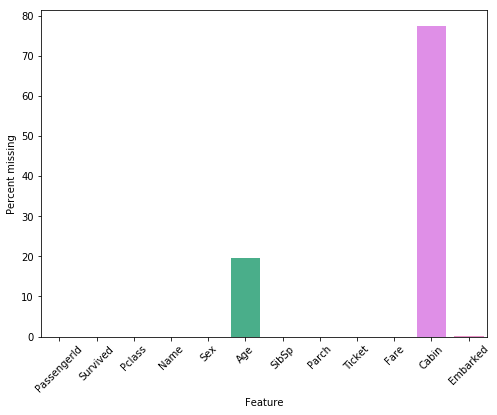

In [14]:
'''Deal with missing values. First, calculate the percentage of
missing values for every column, and plot them as a bar chart'''

null_vals = mydf_train.isnull().sum()/len(mydf_train)*100
null_vals = pd.DataFrame(null_vals)
null_vals.reset_index(inplace = True)
null_vals.columns = ["Feature","Percent missing"]
plt.figure(figsize = (8,6))
plt.xticks(rotation=45)
sns.barplot(x = "Feature",y ="Percent missing",data = null_vals)

From the above plot 

(1) Cabin has ~80% missing values. It can be challenging to "fill in" or impute so many missing values. Let's try dropping the column "Cabin".

(2) Age has ~20% missing values. We'll try to impute these.

(3) Embarked column have very little missing values. We will impute these values.

(4) If the target variable (Survived) had any missing values, then those rows would have to be removed for pure supervised learning (like our current endeavor). But we don't seem to have any null values in the Survived column.

We are going to preprocess this dataset in these steps--

(1) Convert the entire dataframe to an array of numbers. This itself will happen in two steps -- (a) Convert object types and string types to category type (b) map and convert cateogries of numbers.

(2) Impute or "fill in" missing values or NaNs. Here, continuous (e.g. Fare column) and categorical values are treated separately. For filling up missing continuous values, we use the median value of that column, and to fill up missing categorical values, we use 0. Also, we add a separate "marker" column for both that notes whether a value has been imputed or not.

(3) Finally, for a lot of the algorithms like k-NN, we scale the data to lie between 0 and 1 with mean zero and unit variance.

In [15]:
mydf_train_1 = mydf_train.drop("Cabin",axis = 1)
print(mydf_train_1.shape)
mydf_train_1.head(2)

(917, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C


In [16]:
#Check types of each column with the dataframe info () method
mydf_train_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 917 entries, 0 to 916
Data columns (total 11 columns):
PassengerId    917 non-null int64
Survived       917 non-null int64
Pclass         917 non-null int64
Name           917 non-null object
Sex            917 non-null object
Age            738 non-null float64
SibSp          917 non-null int64
Parch          917 non-null int64
Ticket         917 non-null object
Fare           917 non-null float64
Embarked       915 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 78.9+ KB


In [17]:
'''You can see that several of the columns or features are "object" type
These need to be changed to category before we can convert those to 
mappings and numbers. So we define a function to convert 
object types and string types to category type'''

def str_to_cat(my_df):
    for p,q in my_df.items(): #my_df.items() is a generator in Python
        if is_string_dtype(q): 
            my_df[p] = q.astype('category').cat.as_ordered()
    return my_df

In [18]:
# Apply the str_to_cat function
mydf_train_2 = str_to_cat(mydf_train_1)
mydf_train_2.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C


In [19]:
#Check dtypes of columns after this operation
mydf_train_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 917 entries, 0 to 916
Data columns (total 11 columns):
PassengerId    917 non-null int64
Survived       917 non-null int64
Pclass         917 non-null int64
Name           917 non-null category
Sex            917 non-null category
Age            738 non-null float64
SibSp          917 non-null int64
Parch          917 non-null int64
Ticket         917 non-null category
Fare           917 non-null float64
Embarked       915 non-null category
dtypes: category(4), float64(2), int64(5)
memory usage: 128.4 KB


In [20]:
'''Check the cateogry mapping for Embarked and Sex column. We need this
later'''
print(mydf_train_2.Embarked.cat.categories)
print(mydf_train_2.Sex.cat.categories)

Index(['C', 'Q', 'S'], dtype='object')
Index(['female', 'male'], dtype='object')


All object categories like Name, Sex, and Ticket have been converted to Category dtype !

In [21]:
'''Define impute functions. Impute NaNs with -1 and then 
we add 1 to make it 0. For each  continuous variables, 
we impute missing values with median values of that column, and 
for every variable where any rows were imputed, 
add a separate 'imputed or not' column'''

def mydf_to_nums(my_df, feature, null_status):
    if not is_numeric_dtype(feature):
        my_df[null_status] = feature.cat.codes + 1
        
def mydf_imputer(my_df, feature, null_status, null_table):
    if is_numeric_dtype(feature):
        if pd.isnull(feature).sum() or (null_status in null_table):
            my_df[null_status+'_na'] = pd.isnull(feature)
            filler = null_table[null_status] if null_status in null_table else feature.median()
            my_df[null_status] = feature.fillna(filler)
            null_table[null_status] = filler
    return null_table   

def mydf_preprocessor(my_df, null_table):
    '''null_table  = your table or None'''
    
    if null_table is None: 
        null_table = dict()
    for p,q in my_df.items(): 
        null_table = mydf_imputer(my_df, q, p, null_table)
    for p,q in my_df.items(): 
        mydf_to_nums(my_df, q, p)
    my_df = pd.get_dummies(my_df, dummy_na = True)
    res = [my_df, null_table]
    return res

In [22]:
mydf_train_3,my_table = mydf_preprocessor(mydf_train_2,null_table = None)

In [23]:
#Check dataframe
mydf_train_3.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_na
0,1,0,3,112,2,22.0,1,0,538,7.2500,3,False
1,2,1,1,196,1,38.0,1,0,613,71.2833,1,False


In [24]:
'''Please store the null_table, category mapping separately.
We will need to process the test dataset using these values'''
my_table

{'Age': 28.0}

In [25]:
'''Now, let's separate the X and Y variables (vertical split of the 
dataframe). Here the Y column is the variable we are trying to predict, 
survived or not(0 = No, 1 = Yes)'''

Y_train = mydf_train_3["Survived"]
X_train = mydf_train_3.drop(["Survived"],axis = 1)

print(X_train.shape,Y_train.shape)

(917, 11) (917,)


In [26]:
'''Standardize the continuous variables. One way to do this:

(1) We calculate the arithmetic mean (AM) and standard deviation (SD)
of that column,
(2) subtract the AM from each value to get a new value
(3) divide the new value by the SD

Please see preprocessing under scikit-learn page for more information.
Here, the two continuous variable columns are (a) Age and, (b) Fare'''

scaler = preprocessing.StandardScaler().fit(X_train[["Age","Fare"]])
X_train[["Age","Fare"]] = pd.DataFrame(scaler.transform(X_train[["Age","Fare"]]))
X_train.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_na
0,1,3,112,2,-0.571942,1,0,538,-0.501823,3,False
1,2,1,196,1,0.651550,1,0,613,0.786791,1,False


In [49]:
'''Store the scaler as a joblib file'''
!mkdir scaler_trainset
scaler_name = '/Users/ram/Desktop/DS 2019/scaler_trainset/scaler_train.sav'
joblib.dump(scaler,scaler_name)

['/Users/ram/Desktop/DS 2019/scaler_trainset/scaler_train.sav']

In [29]:
'''Preprocess the validation set in exactly the same way you 
preprocessed the training set

(1) We start by dropping the Cabin column because that was dropped in the
training set'''

mydf_valid_1 = mydf_valid.drop(["Cabin"],axis = 1)

In [30]:
#Check valid data
mydf_valid_1.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
917,918,0,1,"Ostby, Miss. Helene Ragnhild",female,22.0,0,1,113509,61.9792,C
918,919,0,3,"Daher, Mr. Shedid",male,22.5,0,0,2698,7.2250,C


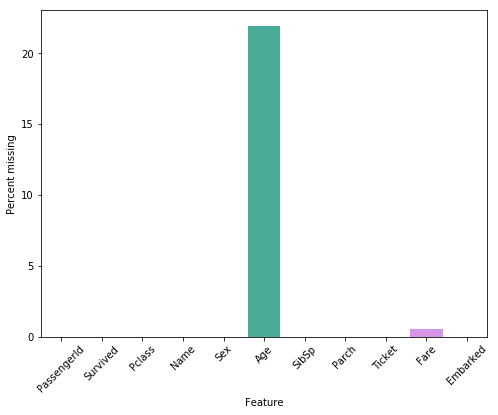

In [31]:
'''(2) Check for null values in the validation set and deal with it'''
null_vals = mydf_valid_1.isnull().sum()/len(mydf_valid_1)*100
null_vals = pd.DataFrame(null_vals)
null_vals.reset_index(inplace = True)
null_vals.columns = ["Feature","Percent missing"]
plt.figure(figsize = (8,6))
plt.xticks(rotation=45)
sns.barplot(x = "Feature",y ="Percent missing",data = null_vals)

In [32]:
'''In the validation data, Age and Fare columns have missing values.
The training data did not have missing values for the Fare column. One way
to address this is to drop rows of validation data where Fare = null'''

mydf_valid_1 = mydf_valid_1[pd.notnull(mydf_valid_1['Fare'])]
print(mydf_valid_1.shape)
mydf_valid_1.head(2)

(195, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
917,918,0,1,"Ostby, Miss. Helene Ragnhild",female,22.0,0,1,113509,61.9792,C
918,919,0,3,"Daher, Mr. Shedid",male,22.5,0,0,2698,7.2250,C


In [33]:
'''(3) Map categories to numbers for validation set'''
mydf_valid_2 = str_to_cat(mydf_valid_1)

In [34]:
#Make sure category mapping are consistent across the two data sets
print(mydf_valid_2.Sex.cat.categories)

Index(['female', 'male'], dtype='object')


In [35]:
#Make sure category mapping are consistent across the two data sets
print(mydf_valid_2.Embarked.cat.categories)

Index(['C', 'Q', 'S'], dtype='object')


Great! The category mappings are consistent. Please verify with that of the training set

In [36]:
''' (4) Let's proceed with the imputation and convert strings into 
numbers for the validation set. Use my_table for the imputed values'''

mydf_valid_3,my_table1 = mydf_preprocessor(mydf_valid_2,
                                         null_table = my_table)
print(mydf_valid_3.shape)
mydf_valid_3.head(3)

(195, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_na
917,918,0,1,137,1,22.0,0,1,6,61.9792,1,False
918,919,0,3,52,2,22.5,0,0,63,7.2250,1,False
919,920,1,1,23,2,41.0,0,0,4,30.5000,3,False


In [37]:
'''(5) Separate out the X and Y for validation before proceeding'''

Y_valid = mydf_valid_3["Survived"]
X_valid = mydf_valid_3.drop(["Survived"],axis = 1)

print(X_valid.shape,Y_valid.shape)

(195, 11) (195,)


In [38]:
X_valid.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_na
917,918,1,137,1,22.0,0,1,6,61.9792,1,False
918,919,3,52,2,22.5,0,0,63,7.2250,1,False


In [39]:
'''(6) Standardize the validation set continuous columns 
using mean and standard deviation for the same, from the training set.
Since we made an object "scaler", already, we can simply re-use to do this'''

X_valid[["Age","Fare"]] = scaler.transform(X_valid[["Age","Fare"]])
X_valid.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_na
917,918,1,137,1,-0.571942,0,1,6,0.599554,1,False
918,919,3,52,2,-0.533707,0,0,63,-0.502327,1,False


# V. First model

In [40]:
'''Let's now train a k-NN model and evaluate it on the validation set. 
First, let's use the default values for the k-NN hyperparameters -
n_neighbors = 5,weights = 'uniform'). KNN has more hyperparameters such as
leaf_size, metric, etc. But, these are two key hyperparamters'''

my_knn_model = KNeighborsClassifier(n_neighbors = 5,weights = 'uniform')
my_knn_model.fit(X_train,Y_train)

#Predict on the validation set
Y_pred = my_knn_model.predict(X_valid)

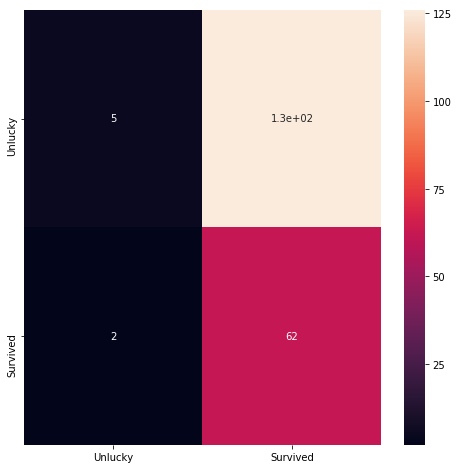

In [41]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix

my_knn_cmatrix = confusion_matrix(Y_valid,Y_pred)

my_knn_df = pd.DataFrame(my_knn_cmatrix)
plt.figure(figsize = (8,8))
sns.heatmap(my_knn_df, xticklabels = ["Unlucky","Survived"],
            yticklabels = ["Unlucky","Survived"],annot = True)

In [42]:
'''Print out a bunch of model performance metrics. We will do a deep dive 
on each metric in later in this course'''

print(accuracy_score(Y_valid,Y_pred),
      matthews_corrcoef(Y_valid,Y_pred),f1_score(Y_valid,Y_pred))

0.3435897435897436 0.017461213161094905 0.492063492063492


# VI. Hyperparameter tuning

In [43]:
'''Determining the optimal value of k for k-NN on the Titanic dataset'''

num_neighs = list()
accuracy_list = list()


for neighbor in range(1,20):
    my_knn_model = KNeighborsClassifier(n_neighbors = neighbor,weights = 'uniform')
    my_knn_model.fit(X_train,Y_train)
    Y_pred = my_knn_model.predict(X_valid)
    accuracy = accuracy_score(Y_valid,Y_pred)
    num_neighs.append(neighbor)
    accuracy_list.append(accuracy)

In [44]:
'''Print it out as a table'''
eval_df =  pd.DataFrame({"Num of neighbors": num_neighs,"Valid accuracy Score": accuracy_list})
eval_df

,Num of neighbors,Valid accuracy Score
0,1,0.502564
1,2,0.512821
2,3,0.358974
3,4,0.394872
4,5,0.343590
5,6,0.369231
6,7,0.338462
7,8,0.343590
8,9,0.338462
9,10,0.338462


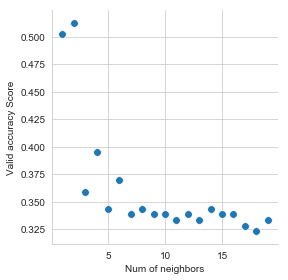

In [45]:
#Plot the above as an accuracy Vs validation set accuracy of the model
sns.set_style("whitegrid")
sns.pairplot(eval_df,x_vars = "Num of neighbors",
             y_vars = "Valid accuracy Score",plot_kws = {'s': 60},height = 4.0)

# VII. Combining the train and validation datasets

In [46]:
'''Congrats, K = 2 seems to give the best validation 
set accuracy (= 0.51) !!! We will use this value to train our final
model. OK, so how do we save this trained and 
hyperparameter tuned model for later use? First, we club together, the
train and valid set. Then, we make and 
train a model with K = 2. Then save it with joblib, which we imported 
earlier. Finally, we preprocess the test set and evaluate this model.'''

X_train_full = pd.concat([X_train,X_valid],ignore_index = True)
print(X_train_full.shape)
X_train_full.head(2)

(1112, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_na
0,1,3,112,2,-0.571942,1,0,538,-0.501823,3,False
1,2,1,196,1,0.651550,1,0,613,0.786791,1,False


In [47]:
# Do the same for Y
Y_train_full = pd.concat([Y_train,Y_valid],ignore_index = True)
print(Y_train_full.shape)

(1112,)


# VIII. Building and Saving the trained model

In [48]:
knn_model_fin = KNeighborsClassifier(n_neighbors = 2,weights = 'uniform')
knn_model_fin.fit(X_train_full,Y_train_full)

!mkdir knn_model
knn_model_name = '/Users/ram/Desktop/DS 2019/knn_model/knn_model_final.sav'
joblib.dump(knn_model_fin,knn_model_name)

['/Users/ram/Desktop/DS 2019/knn_model/knn_model_final.sav']